In [1]:
# === Block 0: Prepare merged dataset paths & class labels ===
import glob, os, random

# Emotion labels (common between both datasets)
CLASS_LIST = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Dataset roots (your structure)
BASE_DIR = "/kaggle/input/emotion-datasets-rafdb-ferplus/datasets"
raf_train = os.path.join(BASE_DIR, "RAF-DB/train")
raf_test  = os.path.join(BASE_DIR, "RAF-DB/test")
fer_train = os.path.join(BASE_DIR, "fer2013plus/train")
fer_test  = os.path.join(BASE_DIR, "fer2013plus/test")

def collect_images(base_path, dataset_name):
    collected = []
    for idx, emotion in enumerate(CLASS_LIST):
        # Match both lower/upper folder names
        for folder_name in [emotion, emotion.capitalize()]:
            pattern_jpg = os.path.join(base_path, folder_name, "*.jpg")
            pattern_png = os.path.join(base_path, folder_name, "*.png")
            pattern_jpeg = os.path.join(base_path, folder_name, "*.jpeg")
            for path in glob.glob(pattern_jpg) + glob.glob(pattern_png) + glob.glob(pattern_jpeg):
                collected.append((path, idx))
    print(f"{dataset_name}: Collected {len(collected)} images from {base_path}")
    return collected

# Collect from both datasets
image_paths = collect_images(raf_train, "RAF-DB Train") + collect_images(fer_train, "FERPlus Train")
val_paths   = collect_images(raf_test, "RAF-DB Test") + collect_images(fer_test, "FERPlus Test")

# Shuffle the dataset
random.shuffle(image_paths)
random.shuffle(val_paths)

print(f"\n✅ Total merged training samples: {len(image_paths)}")
print(f"✅ Total merged validation samples: {len(val_paths)}")
if len(image_paths) > 0:
    print("Example sample:", image_paths[0])
else:
    print("⚠️ No images found — check dataset mount path or file types!")


RAF-DB Train: Collected 11566 images from /kaggle/input/emotion-datasets-rafdb-ferplus/datasets/RAF-DB/train
FERPlus Train: Collected 14713 images from /kaggle/input/emotion-datasets-rafdb-ferplus/datasets/fer2013plus/train
RAF-DB Test: Collected 2906 images from /kaggle/input/emotion-datasets-rafdb-ferplus/datasets/RAF-DB/test
FERPlus Test: Collected 3721 images from /kaggle/input/emotion-datasets-rafdb-ferplus/datasets/fer2013plus/test

✅ Total merged training samples: 26279
✅ Total merged validation samples: 6627
Example sample: ('/kaggle/input/emotion-datasets-rafdb-ferplus/datasets/fer2013plus/train/neutral/fer0025582.png', 4)


In [2]:
# === Block 1: Build TensorFlow datasets ===
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
SEED = 42

# --- Keras augmentation layers (TF-native, fast, GPU-accelerated) ---
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(factor=0.08),
])

def load_and_preprocess(path, label, augment=False):
    # Decode & resize
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Apply augmentation if enabled
    if augment:
        img = augment_layers(img)
    return img, label

def make_dataset(image_label_pairs, augment=False):
    paths = [p for p, _ in image_label_pairs]
    labels = [l for _, l in image_label_pairs]

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if augment:
        ds = ds.shuffle(buffer_size=4096, seed=SEED)
    ds = ds.map(lambda p, l: load_and_preprocess(p, l, augment), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

# ✅ Create the datasets
train_ds = make_dataset(image_paths, augment=True)
val_ds   = make_dataset(val_paths, augment=False)

# --- Quick sanity check ---
for x_batch, y_batch in train_ds.take(1):
    print("Batch shape:", x_batch.shape, "dtype:", x_batch.dtype)
    print("Labels shape:", y_batch.shape, "dtype:", y_batch.dtype)


2025-11-06 04:19:16.754821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762402757.178126      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762402757.296330      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1762402778.541043      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762402778.541899      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Batch shape: (32, 224, 224, 3) dtype: <dtype: 'float32'>
Labels shape: (32,) dtype: <dtype: 'int32'>


In [3]:
# === Block 2: Model (ResNet50 + CBAM + Multi-Head Attention) ===
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# --- CBAM (Channel + Spatial Attention) ---
def cbam_block(x, reduction=8):
    ch = x.shape[-1]

    # Channel attention
    avg_pool = layers.GlobalAveragePooling2D(keepdims=True)(x)
    max_pool = layers.GlobalMaxPooling2D(keepdims=True)(x)

    shared_mlp = tf.keras.Sequential([
        layers.Dense(ch // reduction, activation='relu'),
        layers.Dense(ch, activation='sigmoid')
    ])

    attn_channel = layers.Add()([shared_mlp(avg_pool), shared_mlp(max_pool)])
    x = layers.Multiply()([x, attn_channel])

    # Spatial attention (use Keras layers instead of tf ops)
    avg_spatial = layers.Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
    max_spatial = layers.Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_spatial, max_spatial])
    spat_attn = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spat_attn])
    return x

# --- Model builder ---
def build_model(input_shape=(224, 224, 3), num_classes=len(CLASS_LIST)):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False

    inp = layers.Input(shape=input_shape)
    x = base(inp, training=False)
    x = cbam_block(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Multi-Head Attention block
    seq = layers.Reshape((1, x.shape[-1]))(x)
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64)(seq, seq)
    attn = layers.Flatten()(attn)

    # Combine attention outputs
    x = layers.Concatenate()([x, attn])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inp, out)

# ✅ Build & summarize
model = build_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 1,      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1, 1,      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 1, 1,      │  1,050,880 │ global_average_p… │
│ (Sequential)        │ 2048)             │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1,      │          0 │ sequential_1[0][… │
│                     │ 2048)             │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ resnet50[0][0],   │
│                     │ 2048)             │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 2)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 1)   │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 2048)             │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 2048)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 2048)   │  2,099,968 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,097,664 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_2[0][0]   

 Total params: 28,841,962 (110.02 MB)

 Trainable params: 5,253,226 (20.04 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [4]:
# === Block 3: Two-Phase Training (Frozen + Fine-tune) ===
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np, os

# --- Compute class weights directly from your integer labels ---
train_labels = [lbl for _, lbl in image_paths]
unique_labels = np.unique(train_labels)
cw = compute_class_weight(class_weight="balanced", classes=unique_labels, y=train_labels)
class_weights = {int(label): float(weight) for label, weight in zip(unique_labels, cw)}
print("✅ Class weights:", class_weights)

# --- Compile model for sparse labels ---
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=loss_fn, metrics=["accuracy"])

# --- Checkpoint setup ---
CKPT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
MODEL_SAVE = os.path.join(CKPT_DIR, "resnet50_cbam_mha_best.keras")

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(MODEL_SAVE, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# === Phase 1: Train top (frozen) layers ===
print("🚀 Phase 1: Training frozen base...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

# === Phase 2: Fine-tune deeper layers ===
print("\n🔓 Phase 2: Fine-tuning top 30 layers...")
for layer in model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

opt_fine = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt_fine, loss=loss_fn, metrics=["accuracy"])

MODEL_SAVE_FINE = os.path.join(CKPT_DIR, "resnet50_cbam_mha_finetuned.keras")
callbacks_fine = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    ModelCheckpoint(MODEL_SAVE_FINE, monitor="val_accuracy", save_best_only=True, verbose=1)
]

print("\n🚀 Phase 2: Training fine-tuned model...")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_fine
)

print(f"\n✅ Training complete. Model saved to: {MODEL_SAVE_FINE}")


✅ Class weights: {1: 4.823604992657856, 2: 4.694355126831011, 3: 0.9178192232467169, 4: 0.3413211762261014, 5: 2.2098049108644466, 6: 0.9026861775212971}
🚀 Phase 1: Training frozen base...
Epoch 1/15


I0000 00:00:1762402797.843260      61 service.cc:148] XLA service 0x7ac640001c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762402797.844597      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762402797.844615      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762402800.164262      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/822 ━━━━━━━━━━━━━━━━━━━━ 5:29:03 24s/step - accuracy: 0.2500 - loss: 1.8324

I0000 00:00:1762402808.012407      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


822/822 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1875 - loss: 1.9203
Epoch 1: val_accuracy improved from -inf to 0.19647, saving model to /kaggle/working/checkpoints/resnet50_cbam_mha_best.keras
822/822 ━━━━━━━━━━━━━━━━━━━━ 242s 265ms/step - accuracy: 0.1875 - loss: 1.9202 - val_accuracy: 0.1965 - val_loss: 2.6863 - learning_rate: 1.0000e-04
Epoch 2/15
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2967 - loss: 1.7121
Epoch 2: val_accuracy improved from 0.19647 to 0.21609, saving model to /kaggle/working/checkpoints/resnet50_cbam_mha_best.keras
822/822 ━━━━━━━━━━━━━━━━━━━━ 159s 193ms/step - accuracy: 0.2968 - loss: 1.7121 - val_accuracy: 0.2161 - val_loss: 5.4500 - learning_rate: 1.0000e-04
Epoch 3/15
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3349 - loss: 1.6969
Epoch 3: val_accuracy improved from 0.21609 to 0.26769, saving model to /kaggle/working/checkpoints/resnet50_cbam_mha_best.keras
822/822 ━━━━━━━━━━━━━━━━━━━━ 157s 191ms/step - accuracy: 0.3349 -

In [5]:
# === Phase 3: Extended fine-tuning for higher accuracy ===
print("\n🚀 Phase 3: Deep fine-tuning (unfreeze top 80 layers)...")

for layer in model.layers[-80:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

opt_deep = tf.keras.optimizers.Adam(learning_rate=5e-6)
model.compile(optimizer=opt_deep, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

MODEL_SAVE_DEEP = os.path.join(CKPT_DIR, "resnet50_cbam_mha_deep_finetuned.keras")
callbacks_deep = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(MODEL_SAVE_DEEP, monitor='val_accuracy', save_best_only=True, verbose=1)
]

history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_deep
)

print(f"✅ Deep fine-tuning complete! Final model saved to: {MODEL_SAVE_DEEP}")



🚀 Phase 3: Deep fine-tuning (unfreeze top 80 layers)...
Epoch 1/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.3948 - loss: 1.4335
Epoch 1: val_accuracy improved from -inf to 0.67421, saving model to /kaggle/working/checkpoints/resnet50_cbam_mha_deep_finetuned.keras
822/822 ━━━━━━━━━━━━━━━━━━━━ 431s 437ms/step - accuracy: 0.3948 - loss: 1.4335 - val_accuracy: 0.6742 - val_loss: 0.9316 - learning_rate: 5.0000e-06
Epoch 2/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3899 - loss: 1.4363
Epoch 2: val_accuracy improved from 0.67421 to 0.68643, saving model to /kaggle/working/checkpoints/resnet50_cbam_mha_deep_finetuned.keras
822/822 ━━━━━━━━━━━━━━━━━━━━ 334s 406ms/step - accuracy: 0.3899 - loss: 1.4363 - val_accuracy: 0.6864 - val_loss: 0.8919 - learning_rate: 5.0000e-06
Epoch 3/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4057 - loss: 1.3963
Epoch 3: val_accuracy improved from 0.68643 to 0.71510, saving model to /kaggle/working/checkpoints/resnet

🚀 Starting Final Fine-Tuning for ResNet50 CBAM MHA Model
✅ Mixed precision enabled.
🔓 Unfroze top 40 layers for fine-tuning
✅ Model recompiled with Adam (1e-5) & SparseCategoricalCrossentropy
🔥 Training with smaller batch & selective unfreezing...
Epoch 1/25
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5370 - loss: 1.3419
Epoch 1: val_accuracy improved from -inf to 0.77848, saving model to /kaggle/working/checkpoints/resnet50_cbam_mha_final_stable.keras
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 498s 128ms/step - accuracy: 0.5370 - loss: 1.3419 - val_accuracy: 0.7785 - val_loss: 0.6790 - learning_rate: 1.0000e-05
Epoch 2/25
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5921 - loss: 1.1760
Epoch 2: val_accuracy did not improve from 0.77848
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 392s 119ms/step - accuracy: 0.5921 - loss: 1.1760 - val_accuracy: 0.7599 - val_loss: 0.7412 - learning_rate: 1.0000e-05
Epoch 3/25
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6044 - loss: 1.

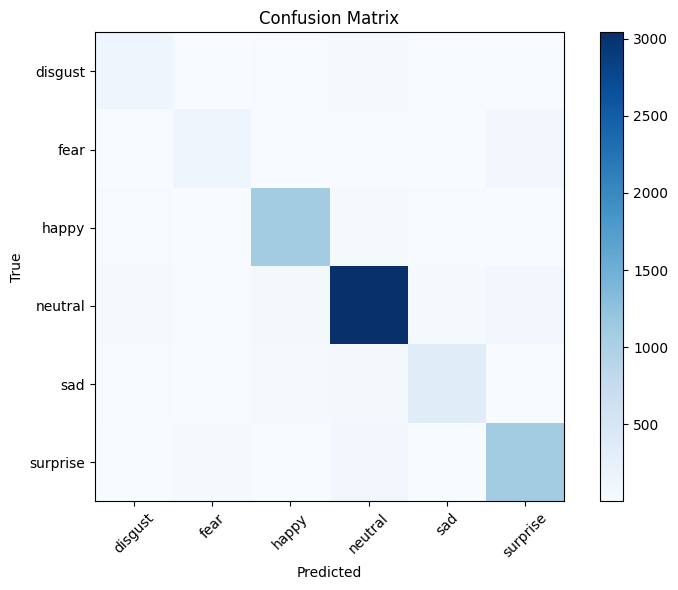


🏁 Final Overall Accuracy (Computed from Confusion Matrix): 87.72%

✅ Model evaluation complete. Final model path: /kaggle/working/checkpoints/resnet50_cbam_mha_final_stable.keras


In [6]:
# === Block 5: Final Stable Fine-Tuning (ResNet50 + CBAM + MHA) ===
import os, tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("🚀 Starting Final Fine-Tuning for ResNet50 CBAM MHA Model")

# 1️⃣ --- Safety & GPU optimization ---
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # reduce log noise
try:
    tf.config.optimizer.set_jit(False)  # disable XLA constant folding stalls
except Exception:
    pass

# enable mixed precision (reduce memory usage)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("✅ Mixed precision enabled.")
except Exception as e:
    print("⚠️ Mixed precision unavailable:", e)

# enable memory growth (prevents full GPU allocation)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Memory growth enabled for", gpu)
    except:
        pass

# 2️⃣ --- Unfreeze top layers safely ---
UNFREEZE_LAYERS = 40
for layer in model.layers[:-UNFREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[-UNFREEZE_LAYERS:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

print(f"🔓 Unfroze top {UNFREEZE_LAYERS} layers for fine-tuning")

# 3️⃣ --- Lower batch size & re-create datasets ---
BATCH_SIZE = 8  # safe for 6–16 GB GPUs
if 'make_dataset' in globals():
    train_ds = make_dataset(image_paths, augment=True)
    val_ds = make_dataset(val_paths, augment=False)
else:
    print("⚠️ make_dataset() not found, using existing train_ds/val_ds")

# 4️⃣ --- Recompile model ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
print("✅ Model recompiled with Adam (1e-5) & SparseCategoricalCrossentropy")

# 5️⃣ --- Callbacks ---
CKPT_DIR = CKPT_DIR if 'CKPT_DIR' in globals() else "/kaggle/working/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
MODEL_SAVE_FINAL = os.path.join(CKPT_DIR, "resnet50_cbam_mha_final_stable.keras")

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_FINAL, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# 6️⃣ --- Start fine-tuning ---
print("🔥 Training with smaller batch & selective unfreezing...")
history_final = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

# === Final Evaluation + Confusion Matrix + Final Accuracy ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n📊 Evaluating final fine-tuned model...\n")

y_true, y_pred = [], []
for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

# Auto-detect which classes are actually present in validation set
unique_labels = sorted(np.unique(y_true))
used_names = [CLASS_LIST[i] for i in unique_labels]

# --- Classification Report ---
print("📋 Classification Report (Auto-Aligned Classes):\n")
print(classification_report(
    y_true, y_pred,
    labels=unique_labels,
    target_names=used_names,
    digits=4
))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(used_names)), used_names, rotation=45)
plt.yticks(range(len(used_names)), used_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- Final Overall Accuracy ---
final_acc = accuracy_score(y_true, y_pred) * 100
print(f"\n🏁 Final Overall Accuracy (Computed from Confusion Matrix): {final_acc:.2f}%")

print(f"\n✅ Model evaluation complete. Final model path: {MODEL_SAVE_FINAL}")
